# Artist classification using BERT
This notebook uses a transformer-based model BERT on the task of artist classification.

The motivation behind using this model is to utilize its context understanding and trained knowledge to fine-tune lyrics of different artist.

We'll first use the pretrained model ito transform the lyrics into BERT vector embeddings and run a kNN algorithm over all the vector embeddings. Then we'll be fine-tuning the model on artist classification.

In [1]:
import os
cache_folder = '/mount/studenten-temp1/users/knupleun/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = cache_folder

## Preparing the data

In [2]:
from datasets import load_dataset

dataset_folder = '../data/'

dataset = load_dataset('csv',
                     data_files={
                        'train': dataset_folder + 'songs_train.txt',
                        'test': dataset_folder + 'songs_test.txt',
                        'dev': dataset_folder + 'songs_dev.txt',
                     },
#                     split='train[:10%]',
                     #split='train[50%:52%]',
                     column_names=['artist', 'title', 'lyrics'],
                     sep='\t')

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Get all artists to have a class for label mapping

In [3]:
from datasets import ClassLabel, Dataset

if len(dataset) == 3:
    union_artists = set(dataset['train']['artist']) | set(dataset['test']['artist']) | set(dataset['dev']['artist'])
else:
    union_artists = set(dataset['artist'])

artists = ClassLabel(names=list(union_artists))

## Transform lyrics into BERT embeddings
We're using the classic pre-trained BERT model, passing in the lyrics and getting out the final hidden states (or output vectors) of the model.

In [4]:
from transformers import AutoTokenizer, AutoModel

# but for now I'm only gonna use bert, cuz RAM
model_name = "bert-base-uncased"

model =  AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def add_sentence_special_token(example):
    example['lyrics'] = example['lyrics'].replace(' NEWLINE ', ' [SEP] ')

    return example

In [11]:
from transformers import FeatureExtractionPipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.notebook import tqdm

feature_extract_pipeline = FeatureExtractionPipeline(model=model, tokenizer=tokenizer, framework='pt',  device=1)

def get_embeddings(dataset):
    dataset = dataset.map(add_sentence_special_token)

    embeddings = []
    labels = artists.str2int(dataset['artist'])

    pipe = feature_extract_pipeline(KeyDataset(dataset, 'lyrics'), batch_size=32, truncation=True)

    for embedding in tqdm(pipe, total=len(dataset)):
        clr_embedding = embedding[0][0]

        embeddings.append(clr_embedding)

    return embeddings, labels

In [13]:
train_num_examples = 10000
train_examples = dataset['train'].select(range(train_num_examples))

train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

In [15]:
test_num_examples = 100
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)

  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
import matplotlib.pyplot as plt
import evaluate

acc_metric = evaluate.load("accuracy")

def evalute_knn(embeddings, references):
    diff_setups = []
    for n in range(1,30):
        neigh.set_params(n_neighbors=n)
        predictions = neigh.predict(embeddings)

        diff_setups.append({'n': n, 'predictions': predictions})

    scores = []
    n_neighbours = []
    for i, setup in enumerate(diff_setups):
        metric = acc_metric.compute(predictions=setup['predictions'], references=test_lables)

        score = metric['accuracy']
        scores.append(score)
        n_neighbours.append(i+1)

        print('n:', i+1, 'acc:', score)

    return n_neighbours, scores

Matplotlib is building the font cache; this may take a moment.


n: 1 acc: 0.03
n: 2 acc: 0.03
n: 3 acc: 0.03
n: 4 acc: 0.04
n: 5 acc: 0.05
n: 6 acc: 0.05
n: 7 acc: 0.05
n: 8 acc: 0.04
n: 9 acc: 0.04
n: 10 acc: 0.05
n: 11 acc: 0.06
n: 12 acc: 0.06
n: 13 acc: 0.06
n: 14 acc: 0.07
n: 15 acc: 0.07
n: 16 acc: 0.07
n: 17 acc: 0.05
n: 18 acc: 0.06
n: 19 acc: 0.06
n: 20 acc: 0.06
n: 21 acc: 0.06
n: 22 acc: 0.06
n: 23 acc: 0.06
n: 24 acc: 0.06
n: 25 acc: 0.06
n: 26 acc: 0.05
n: 27 acc: 0.05
n: 28 acc: 0.05
n: 29 acc: 0.05

Training examples: 10000
Test examples: 100


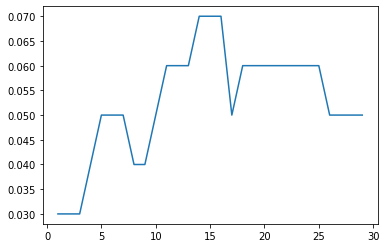

In [17]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()

n: 1 acc: 0.04
n: 2 acc: 0.04
n: 3 acc: 0.04
n: 4 acc: 0.05
n: 5 acc: 0.05
n: 6 acc: 0.05
n: 7 acc: 0.04
n: 8 acc: 0.04
n: 9 acc: 0.05
n: 10 acc: 0.05
n: 11 acc: 0.06
n: 12 acc: 0.08
n: 13 acc: 0.09
n: 14 acc: 0.08
n: 15 acc: 0.09
n: 16 acc: 0.1
n: 17 acc: 0.1
n: 18 acc: 0.1
n: 19 acc: 0.08
n: 20 acc: 0.08
n: 21 acc: 0.08
n: 22 acc: 0.08
n: 23 acc: 0.08
n: 24 acc: 0.08
n: 25 acc: 0.08
n: 26 acc: 0.08
n: 27 acc: 0.08
n: 28 acc: 0.08
n: 29 acc: 0.08

Training examples: 20000
Test examples: 100


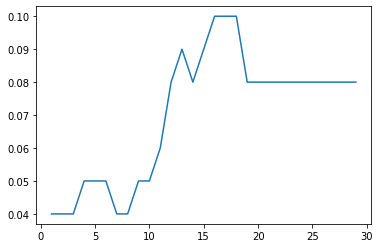

In [21]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()

In [22]:
from sentence_transformers import SentenceTransformer
model_st = SentenceTransformer('all-distilroberta-v1', cache_folder=cache_folder)

def get_embeddings(dataset):
    dataset = dataset.map(add_sentence_special_token)

    labels = artists.str2int(dataset['artist'])
    embeddings = model_st.encode(dataset['lyrics'])

    return embeddings, labels

In [23]:
train_num_examples = 10000
train_examples = dataset['train'].select(range(train_num_examples))

train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

In [24]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

In [25]:
test_num_examples = 100
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)

  0%|          | 0/100 [00:00<?, ?ex/s]

n: 1 acc: 0.04
n: 2 acc: 0.04
n: 3 acc: 0.05
n: 4 acc: 0.06
n: 5 acc: 0.06
n: 6 acc: 0.06
n: 7 acc: 0.06
n: 8 acc: 0.05
n: 9 acc: 0.05
n: 10 acc: 0.05
n: 11 acc: 0.05
n: 12 acc: 0.07
n: 13 acc: 0.06
n: 14 acc: 0.06
n: 15 acc: 0.06
n: 16 acc: 0.07
n: 17 acc: 0.07
n: 18 acc: 0.07
n: 19 acc: 0.07
n: 20 acc: 0.08
n: 21 acc: 0.08
n: 22 acc: 0.08
n: 23 acc: 0.08
n: 24 acc: 0.08
n: 25 acc: 0.08
n: 26 acc: 0.08
n: 27 acc: 0.08
n: 28 acc: 0.08
n: 29 acc: 0.08

Training examples: 10000
Test examples: 100


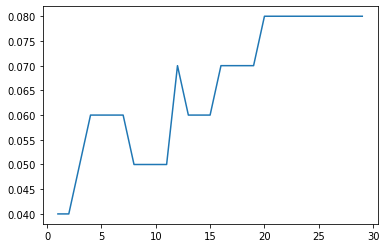

In [26]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()

n: 1 acc: 0.04
n: 2 acc: 0.04
n: 3 acc: 0.04
n: 4 acc: 0.06
n: 5 acc: 0.06
n: 6 acc: 0.05
n: 7 acc: 0.06
n: 8 acc: 0.06
n: 9 acc: 0.07
n: 10 acc: 0.07
n: 11 acc: 0.07
n: 12 acc: 0.08
n: 13 acc: 0.08
n: 14 acc: 0.09
n: 15 acc: 0.09
n: 16 acc: 0.09
n: 17 acc: 0.09
n: 18 acc: 0.09
n: 19 acc: 0.09
n: 20 acc: 0.09
n: 21 acc: 0.09
n: 22 acc: 0.09
n: 23 acc: 0.09
n: 24 acc: 0.1
n: 25 acc: 0.1
n: 26 acc: 0.11
n: 27 acc: 0.11
n: 28 acc: 0.11
n: 29 acc: 0.11

Training examples: 20000
Test examples: 100


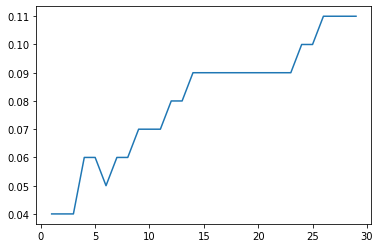

In [47]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()

## Fine-tune BERT on artist classification
Now we're going to fine-tune the BERT model on SequenceClassification task, using the classic pipelines

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/mount/studenten-temp1/users/knupleun/.cache/huggingface'

In [1]:
from datasets import load_dataset

dataset_folder = '../data/'

dataset = load_dataset('csv',
                     data_files={
                        'train': dataset_folder + 'songs_train.txt',
                        'test': dataset_folder + 'songs_test.txt',
                        'dev': dataset_folder + 'songs_dev.txt',
                     },
                     column_names=['artist', 'title', 'lyrics'],
                     sep='\t')

Using custom data configuration default-3fb4b2608fc76309
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-3fb4b2608fc76309/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from datasets import ClassLabel

if len(dataset) == 3:
    union_artists = set(dataset['train']['artist']) | set(dataset['test']['artist']) | set(dataset['dev']['artist'])
else:
    union_artists = set(dataset['artist'])

artists = ClassLabel(names=list(union_artists))

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification 

# This model can be used for loooong documents
model_name = "allenai/longformer-base-4096"

# but for now I'm only gonna use bert, cuz RAM
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=artists.num_classes,
                                                           problem_type="single_label_classification"
                                                          )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
from transformers import AutoTokenizer

# Turn labels to numbers and tokenize input
def transform(batch):
    batch['labels'] = artists.str2int(batch['artist'])
    return tokenizer(batch["lyrics"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(transform, batched=True).remove_columns(['artist', 'title', 'lyrics'])
tokenized_datasets

Parameter 'function'=<function transform at 0x7fd533c89310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46120
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
})

In [27]:
import evaluate
import numpy as np

def compute_metrics(eval_preds):
    f1_metric = evaluate.load("f1")
    acc_metric = evaluate.load("accuracy")
    
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metric = acc_metric.compute(predictions=predictions, references=labels)
    metric.update(f1_metric.compute(predictions=predictions, references=labels, average="micro"))

    return metric

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/mount/studenten-temp1/users/knupleun/artist-classification/teamlabs_model"
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    eval_steps=150,
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # strength of weight decay
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
trainer.train()

***** Running training *****
  Num examples = 46120
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 14415


Step,Training Loss,Validation Loss,Accuracy,F1
150,No log,6.220192,0.003816,0.003816
300,No log,6.197334,0.004510,0.004510
450,No log,6.160745,0.005898,0.005898
600,6.182000,6.063807,0.008500,0.008500
750,6.182000,6.020972,0.011275,0.011275
900,6.182000,5.945712,0.010755,0.010755
1050,5.993800,5.896107,0.014744,0.014744
1200,5.993800,5.794146,0.018040,0.018040
1350,5.993800,5.775152,0.018040,0.018040
1500,5.822300,5.754690,0.016305,0.016305


***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-1000
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-1000/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoin

***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
Saving model checkpoint to /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500
Configuration saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500/config.json
Model weights saved in /mount/studenten-temp1/users/knupi/teamlabs_model/checkpoint-8500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64
***** Running Evaluation *****
  Num exampl

TrainOutput(global_step=14415, training_loss=4.554168419601435, metrics={'train_runtime': 18956.7237, 'train_samples_per_second': 12.165, 'train_steps_per_second': 0.76, 'total_flos': 6.10226018469888e+16, 'train_loss': 4.554168419601435, 'epoch': 5.0})

In [17]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5765
  Batch size = 64


{'eval_loss': 4.75047492980957,
 'eval_accuracy': 0.10893321769297484,
 'eval_f1': 0.10893321769297484,
 'eval_runtime': 70.3119,
 'eval_samples_per_second': 81.992,
 'eval_steps_per_second': 1.294,
 'epoch': 5.0}

## Use fine-tuned BERT to transform lyrics into embeddings
Now that we have fine-tuned the BERT model on artist classification, we're again going to be using its embeddings for kNN classification.

In [27]:
import os
os.environ['TRANSFORMERS_CACHE'] = cache_folder

In [28]:
from datasets import load_dataset

dataset_folder = '../data/'

dataset = load_dataset('csv',
                     data_files={
                        'train': dataset_folder + 'songs_train.txt',
                        'test': dataset_folder + 'songs_test.txt',
                        'dev': dataset_folder + 'songs_dev.txt',
                     },
                     column_names=['artist', 'title', 'lyrics'],
                     sep='\t')

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
from datasets import ClassLabel

if len(dataset) == 3:
    union_artists = set(dataset['train']['artist']) | set(dataset['test']['artist']) | set(dataset['dev']['artist'])
else:
    union_artists = set(dataset['artist'])

artists = ClassLabel(names=list(union_artists))

In [30]:
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"
model_path = "/mount/studenten-temp1/users/knupleun/artist-classification/teamlabs_model/finetuned-bert-artist"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model =  AutoModel.from_pretrained(model_path)

Some weights of the model checkpoint at /mount/studenten-temp1/users/knupleun/artist-classification/teamlabs_model/finetuned-bert-artist were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def add_sentence_special_token(example):
    example['lyrics'] = example['lyrics'].replace(' NEWLINE ', ' [SEP] ')

    return example

In [32]:
from transformers import FeatureExtractionPipeline

feature_extract_pipeline = FeatureExtractionPipeline(model=model, tokenizer=tokenizer, framework='pt',  device=1)

def get_embeddings(dataset):
    dataset = dataset.map(add_sentence_special_token)

    embeddings = []
    labels = artists.str2int(dataset['artist'])

    pipe = feature_extract_pipeline(KeyDataset(dataset, 'lyrics'), batch_size=32, truncation=True)

    for embedding in tqdm(pipe, total=len(dataset)):
        clr_embedding = embedding[0][0]

        embeddings.append(clr_embedding)

    return embeddings, labels

In [33]:
train_num_examples = 10000
train_examples = dataset['train'].select(range(train_num_examples))

train_embeddings, train_labels = get_embeddings(train_examples)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(weights="distance")
neigh.fit(train_embeddings, train_labels)

KNeighborsClassifier(weights='distance')

In [35]:
test_num_examples = 100
test_examples = dataset['test'].select(range(test_num_examples))

test_embeddings, test_lables = get_embeddings(test_examples)

  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
import matplotlib.pyplot as plt
import evaluate

acc_metric = evaluate.load("accuracy")

def evalute_knn(embeddings, references):
    diff_setups = []
    for n in range(1,30):
        neigh.set_params(n_neighbors=n)
        predictions = neigh.predict(embeddings)

        diff_setups.append({'n': n, 'predictions': predictions})

    scores = []
    n_neighbours = []
    for i, setup in enumerate(diff_setups):
        metric = acc_metric.compute(predictions=setup['predictions'], references=test_lables)

        score = metric['accuracy']
        scores.append(score)
        n_neighbours.append(i + 1)

        print('n:', i + 1, 'acc:', score)

    return n_neighbours, scores

n: 1 acc: 0.09
n: 2 acc: 0.09
n: 3 acc: 0.09
n: 4 acc: 0.09
n: 5 acc: 0.1
n: 6 acc: 0.11
n: 7 acc: 0.12
n: 8 acc: 0.11
n: 9 acc: 0.11
n: 10 acc: 0.12
n: 11 acc: 0.13
n: 12 acc: 0.12
n: 13 acc: 0.12
n: 14 acc: 0.14
n: 15 acc: 0.11
n: 16 acc: 0.12
n: 17 acc: 0.12
n: 18 acc: 0.11
n: 19 acc: 0.11
n: 20 acc: 0.12
n: 21 acc: 0.12
n: 22 acc: 0.13
n: 23 acc: 0.11
n: 24 acc: 0.11
n: 25 acc: 0.09
n: 26 acc: 0.09
n: 27 acc: 0.09
n: 28 acc: 0.11
n: 29 acc: 0.11

Training examples: 10000
Test examples: 100


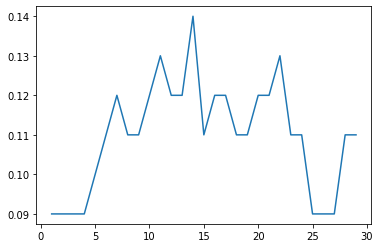

In [37]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()

n: 1 acc: 0.08
n: 2 acc: 0.08
n: 3 acc: 0.08
n: 4 acc: 0.08
n: 5 acc: 0.07
n: 6 acc: 0.09
n: 7 acc: 0.1
n: 8 acc: 0.12
n: 9 acc: 0.12
n: 10 acc: 0.12
n: 11 acc: 0.13
n: 12 acc: 0.13
n: 13 acc: 0.13
n: 14 acc: 0.14
n: 15 acc: 0.13
n: 16 acc: 0.14
n: 17 acc: 0.14
n: 18 acc: 0.13
n: 19 acc: 0.11
n: 20 acc: 0.11
n: 21 acc: 0.11
n: 22 acc: 0.11
n: 23 acc: 0.12
n: 24 acc: 0.13
n: 25 acc: 0.14
n: 26 acc: 0.14
n: 27 acc: 0.14
n: 28 acc: 0.14
n: 29 acc: 0.14

Training examples: 20000
Test examples: 100


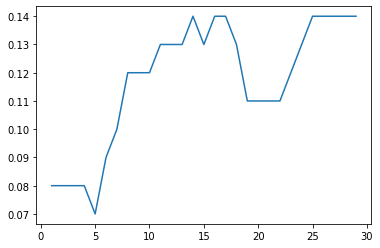

In [42]:
n_neighbours, scores = evalute_knn(test_embeddings, test_lables)

plt.plot(n_neighbours, scores)

print()
print('Training examples:', len(train_embeddings))
print('Test examples:', len(test_embeddings))
plt.show()